# Azerbaijan GP


Key technical improvements:
- Eliminated driver specific encoding to combat veteran bias
- Normalised using StandardScaler to better handle multi-track data distribution
- Added rigorous 5-fold cross validation showing consistent 92% variance across data splits
- Track-specific downforce classification: Analysed Hamilton 2022 telemetry across 16 circuits, categorising by aerodynamic requirements. Baku = "Very Low DF" alongside Monza
- Combined fastest lap times regardless of track status from FP1-FP3 to capture raw speed potential, important on Baku's long straights.
- Grid Position weighting: Enhanced qualifying advantage factor (1.5x multiplier) to properly value qualifying position at Baku


In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=int(weather_df["Rainfall"].any()) # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [4]:
test_sesh=fastf1.get_session(2025,'Baku','R')
test_sesh.load()
test_laps=test_sesh.laps
test_laps

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '8

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:59:36.467000,VER,1,0 days 00:02:08.681000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:43.942000,...,True,Red Bull Racing,0 days 00:57:27.534000,2025-09-21 11:03:53.617,124,1.0,False,,False,False
1,0 days 01:02:20.710000,VER,1,NaT,2.0,1.0,NaT,NaT,0 days 00:00:59.991000,0 days 00:01:04.906000,...,True,Red Bull Racing,0 days 00:59:36.467000,2025-09-21 11:06:02.550,4,1.0,False,,False,False
2,0 days 01:04:59.816000,VER,1,NaT,3.0,1.0,NaT,NaT,0 days 00:00:56.953000,0 days 00:01:03.181000,...,True,Red Bull Racing,0 days 01:02:20.710000,2025-09-21 11:08:46.793,4,1.0,False,,False,False
3,0 days 01:08:11.983000,VER,1,NaT,4.0,1.0,NaT,NaT,0 days 00:00:55.363000,0 days 00:01:06.780000,...,True,Red Bull Racing,0 days 01:04:59.816000,2025-09-21 11:11:25.899,41,1.0,False,,False,False
4,0 days 01:09:59.638000,VER,1,0 days 00:01:47.655000,5.0,1.0,NaT,NaT,0 days 00:00:38.760000,0 days 00:00:43.068000,...,True,Red Bull Racing,0 days 01:08:11.983000,2025-09-21 11:14:38.066,1,1.0,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,0 days 02:25:38.377000,COL,43,0 days 00:01:46.338000,47.0,2.0,NaT,NaT,0 days 00:00:37.750000,0 days 00:00:43.206000,...,True,Alpine,0 days 02:23:52.039000,2025-09-21 12:30:18.122,1,18.0,False,,False,True
964,0 days 02:27:26.813000,COL,43,0 days 00:01:48.436000,48.0,2.0,NaT,NaT,0 days 00:00:37.299000,0 days 00:00:45.881000,...,True,Alpine,0 days 02:25:38.377000,2025-09-21 12:32:04.460,1,19.0,False,,False,True
965,0 days 02:29:14.363000,COL,43,0 days 00:01:47.550000,49.0,2.0,NaT,NaT,0 days 00:00:38.450000,0 days 00:00:43.808000,...,True,Alpine,0 days 02:27:26.813000,2025-09-21 12:33:52.896,1,19.0,False,,False,True
966,0 days 02:31:00.521000,COL,43,0 days 00:01:46.158000,50.0,2.0,NaT,NaT,0 days 00:00:37.674000,0 days 00:00:43.283000,...,True,Alpine,0 days 02:29:14.363000,2025-09-21 12:35:40.446,1,19.0,False,,False,True


In [5]:
laps_df=pd.DataFrame(data=test_laps)
laps_df.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [6]:
laps_df['FreshTyre']

0      True
1      True
2      True
3      True
4      True
       ... 
963    True
964    True
965    True
966    True
967    True
Name: FreshTyre, Length: 968, dtype: bool

In [7]:
laps_df[laps_df['TrackStatus']=='4']

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
1,0 days 01:02:20.710000,VER,1,NaT,2.0,1.0,NaT,NaT,0 days 00:00:59.991000,0 days 00:01:04.906000,...,True,Red Bull Racing,0 days 00:59:36.467000,2025-09-21 11:06:02.550,4,1.0,False,,False,False
2,0 days 01:04:59.816000,VER,1,NaT,3.0,1.0,NaT,NaT,0 days 00:00:56.953000,0 days 00:01:03.181000,...,True,Red Bull Racing,0 days 01:02:20.710000,2025-09-21 11:08:46.793,4,1.0,False,,False,False
52,0 days 01:02:25.368000,RUS,63,NaT,2.0,1.0,NaT,NaT,0 days 00:01:01.108000,0 days 00:01:03.896000,...,True,Mercedes,0 days 00:59:42.280000,2025-09-21 11:06:08.363,4,5.0,False,,False,False
53,0 days 01:05:04.357000,RUS,63,NaT,3.0,1.0,NaT,NaT,0 days 00:00:59.005000,0 days 00:01:02.440000,...,True,Mercedes,0 days 01:02:25.368000,2025-09-21 11:08:51.451,4,5.0,False,,False,False
103,0 days 01:02:21.539000,SAI,55,NaT,2.0,1.0,NaT,NaT,0 days 00:01:00.730000,0 days 00:01:04.862000,...,False,Williams,0 days 00:59:37.126000,2025-09-21 11:06:03.209,4,2.0,False,,False,False
104,0 days 01:05:00.523000,SAI,55,NaT,3.0,1.0,NaT,NaT,0 days 00:00:57.557000,0 days 00:01:03.091000,...,False,Williams,0 days 01:02:21.539000,2025-09-21 11:08:47.622,4,2.0,False,,False,False
154,0 days 01:02:24.282000,ANT,12,NaT,2.0,1.0,NaT,NaT,0 days 00:01:00.591000,0 days 00:01:04.032000,...,False,Mercedes,0 days 00:59:40.383000,2025-09-21 11:06:06.466,4,4.0,False,,False,False
155,0 days 01:05:02.931000,ANT,12,NaT,3.0,1.0,NaT,NaT,0 days 00:00:57.217000,0 days 00:01:03.765000,...,False,Mercedes,0 days 01:02:24.282000,2025-09-21 11:08:50.365,4,4.0,False,,False,False
205,0 days 01:02:22.988000,LAW,30,NaT,2.0,1.0,NaT,NaT,0 days 00:01:00.337000,0 days 00:01:04.850000,...,False,Racing Bulls,0 days 00:59:38.945000,2025-09-21 11:06:05.028,4,3.0,False,,False,False
206,0 days 01:05:02.553000,LAW,30,NaT,3.0,1.0,NaT,NaT,0 days 00:00:57.497000,0 days 00:01:03.274000,...,False,Racing Bulls,0 days 01:02:22.988000,2025-09-21 11:08:49.071,4,3.0,False,,False,False


In [8]:
# We are not getting clean air race pace. We are getting the BEST pace from practice sessions. After talking to some people in the industry, I realised that
# the pace of the car in clean air might not be a very powerful predictive variable given that for most of the race the track WILL have other cars on it (shocker).

def get_best_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])
            # Note that while we are dropping DriverNumber, the 'Driver' column remaining contains abbreviations of the drivers for future mapping.

            laps = laps[(laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True].copy()
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        personalbest_map
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [9]:
"""
track_downforce_mapping = {
    'Monaco': 'Very High DF',
    'Singapore': 'Very High DF',
    'Canada': 'High DF',
    'Silverstone': 'High DF',
    'Imola': 'High DF',
    'Hungary': 'Medium DF',
    'Australia': 'Medium DF',
    'Bahrain': 'Medium DF',
    'Austria': 'Medium DF',
    'Netherlands': 'Medium DF',
    'Spain': 'Low DF',
    'Japan': 'Low DF',
    'Saudi Arabia': 'Low DF',
    'Baku': 'Very Low DF',
    'Belgium': 'Very Low DF',
    'Monza': 'Very Low DF',
    'Miami': 'Very Low DF',
}

Numerical mapping:
downforce_numeric_mapping = {
    'Monaco': 5,
    'Singapore': 5,
    'Canada': 4,
    'Silverstone': 4,
    'Imola': 4,
    'Hungary': 3,
    'Australia': 3,
    'Bahrain': 3,
    'Austria': 3,
    'Netherlands': 3,
    'Spain': 2,
    'Japan': 2,
    'Saudi Arabia': 2,
    'Baku': 1,
    'Belgium': 1,
    'Monza': 1,
    'Miami': 1,
}
"""

"\ntrack_downforce_mapping = {\n    'Monaco': 'Very High DF',\n    'Singapore': 'Very High DF',\n    'Canada': 'High DF',\n    'Silverstone': 'High DF',\n    'Imola': 'High DF',\n    'Hungary': 'Medium DF',\n    'Australia': 'Medium DF',\n    'Bahrain': 'Medium DF',\n    'Austria': 'Medium DF',\n    'Netherlands': 'Medium DF',\n    'Spain': 'Low DF',\n    'Japan': 'Low DF',\n    'Saudi Arabia': 'Low DF',\n    'Baku': 'Very Low DF',\n    'Belgium': 'Very Low DF',\n    'Monza': 'Very Low DF',\n    'Miami': 'Very Low DF',\n}\n\nNumerical mapping:\ndownforce_numeric_mapping = {\n    'Monaco': 5,\n    'Singapore': 5,\n    'Canada': 4,\n    'Silverstone': 4,\n    'Imola': 4,\n    'Hungary': 3,\n    'Australia': 3,\n    'Bahrain': 3,\n    'Austria': 3,\n    'Netherlands': 3,\n    'Spain': 2,\n    'Japan': 2,\n    'Saudi Arabia': 2,\n    'Baku': 1,\n    'Belgium': 1,\n    'Monza': 1,\n    'Miami': 1,\n}\n"

In [10]:
# Build Model Train Data
# To be used for normalization
from sklearn.preprocessing import StandardScaler
import logging

logging.getLogger('fastf1').setLevel(logging.ERROR)

train_sessions={2024:['Singapore'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza','Baku']}
train_df=pd.DataFrame()
y=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R')
        cur_session.load()
        print(f"--------------------------------------------------\nLoaded Data for {year} {race}\n--------------------------------------------------")
        cur_results=cur_session.results
        
        
        #-----------------DROP UNNECESSARY COLUMNS-----------------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        
        
        #------------------CALCULATE TOTAL RACETIME------------
        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        # Deal w Null values
        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        #-------------------------------------------------------------
        
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        
        #----------------------FEATURE ENGINEERING--------------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()
        
        # Calculate average qualifying position per team and subtract the drivers' quali positions from the mean of their combined grid positions.
        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #-------------------------------------------------------------
        
        
        #----------------------GET BEST RACE PACE----------------------
        # Get best track race pace across FP1, FP2 and FP3
        best_race_pace=get_best_race_pace(year,race)
        print("Got Best Race Pace") # Debug
        best_race_pace
        
        best_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=best_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['Best_Pace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------------------------
        
        
        #--------------------MORE FEATURE ENGINEERING------------------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['Best_Pace_seconds'] - cur_results['Best_Pace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['Best_Pace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #--------------------------------------------------------------

        #------------------GET RACE DAY WEATHER DATA--------------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #---------------------------------------------------------------
        
        #---------------------------IS IT BAKU?-------------------------
        if race!='Singapore':
            cur_results['Is_Singapore']=0
        else:
            cur_results['Is_Singapore']=1
        #---------------------------------------------------------------
        
        #-----------------------MAP DOWNFORCE LEVELS & SAFETY CAR PROBABILITIES---------------------
        downforce_map={
            'Monaco': 5,
            'Canada': 4,
            'Silverstone': 4,
            'Imola': 4,
            'Hungary': 3,
            'Australia': 3,
            'Bahrain': 3,
            'Austria': 3,
            'Netherlands': 3,
            'Spain': 2,
            'Japan': 2,
            'Saudi Arabia': 2,
            'Baku': 1,
            'Belgium': 1,
            'Miami': 1,
            'Monza': 1,
            'Singapore': 5
        }
        cur_results['Downforce_Level'] = cur_results['Race'].map(downforce_map)
        
        safety_car_map={
            'Monaco': 43,
            'Canada': 83,
            'Silverstone': 88,
            'Imola': 75,
            'Hungary': 25,
            'Australia': 50,
            'Bahrain': 63,
            'Austria': 38,
            'Netherlands': 50,
            'Spain': 38,
            'Japan': 67,
            'Saudi Arabia': 100,
            'Baku': 57,
            'Belgium': 63,
            'Miami': 67,
            'Monza': 50,
            'Singapore': 83
        }
        cur_results['Safety_Car_Prob'] = cur_results['Race'].map(safety_car_map)
        
        virtual_safety_car_map={
            'Monaco': 29,
            'Canada': 50,
            'Silverstone': 13,
            'Imola': 25,
            'Hungary': 25,
            'Australia': 67,
            'Bahrain': 50,
            'Austria': 50,
            'Netherlands': 50,
            'Spain': 25,
            'Japan': 50,
            'Saudi Arabia': 50,
            'Baku': 43,
            'Belgium': 0,
            'Miami': 67,
            'Monza': 38,
            'Singapore': 33
        }
        cur_results['VSC_Prob'] = cur_results['Race'].map(virtual_safety_car_map)
        
        #-----------------------------------------------------------------------------------------------
        
        #--------------- MAP POSITION GAINS/LOSSES ------------------------
        # Results taken after running script pos_flexibility_calculation.py
        
        flex_map = {
            'PIA': 2.0, 
            'NOR': 3.0, 
            'VER': 0.0, 
            'TSU': 0.8, 
            'HAD': 1.0, 
            'LAW': 0.0, 
            'ALO': 2.2, 
            'STR': -1.6, 
            'OCO': -2.2, 
            'BEA': -1.6, 
            'RUS': -1.2, 
            'ANT': 0.0, 
            'GAS': -0.2, 
            'COL': 1.2, 
            'HAM': -1.2, 
            'LEC': 3.2, 
            'ALB': -5.2, 
            'SAI': 1.0, 
            'BOR': -0.2, 
            'HUL': -0.6
        }
        cur_results['Position_Flexibility'] = cur_results['Driver'].map(downforce_map)
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
 

--------------------------------------------------
Loaded Data for 2024 Singapore
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Australia
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 China
--------------------------------------------------
Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Japan
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Bahrain
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Saudi Arabia
---------

In [11]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,...,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,0 days 01:40:52.571000,62.0,6052.571,97.576180,0.0,-2.0,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
1,VER,red_bull,2.0,0 days 00:00:20.945000,62.0,6073.516,97.903328,1.0,-5.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
2,PIA,mclaren,5.0,0 days 00:00:41.823000,62.0,6094.394,98.182393,4.0,2.0,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
3,RUS,mercedes,4.0,0 days 00:01:01.040000,62.0,6113.611,98.521131,3.0,0.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
4,LEC,ferrari,9.0,0 days 00:01:02.430000,62.0,6115.001,98.490344,8.0,-0.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,0 days 00:01:20.237000,51.0,5686.645,107.190745,16.0,2.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
355,STR,aston_martin,14.0,0 days 00:01:36.392000,51.0,5702.800,107.550191,13.0,1.5,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
356,GAS,alpine,18.0,0 days 00:00:03.865000,50.0,5610.273,107.870717,17.0,1.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
357,COL,alpine,16.0,0 days 00:00:06.325000,50.0,5612.733,107.929087,15.0,-1.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN


In [12]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
       'Year', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_Singapore', 'Downforce_Level',
       'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility'],
      dtype='object')

In [13]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,...,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,97.576180,0.0,-2.0,Singapore,2024,89.646,0.000,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
1,VER,red_bull,2.0,97.903328,1.0,-5.5,Singapore,2024,90.540,0.894,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
2,PIA,mclaren,5.0,98.182393,4.0,2.0,Singapore,2024,90.431,0.785,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
3,RUS,mercedes,4.0,98.521131,3.0,0.5,Singapore,2024,90.125,0.479,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
4,LEC,ferrari,9.0,98.490344,8.0,-0.5,Singapore,2024,90.559,0.913,...,74.650000,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,107.190745,16.0,2.0,Baku,2025,102.428,1.205,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
355,STR,aston_martin,14.0,107.550191,13.0,1.5,Baku,2025,102.771,1.548,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
356,GAS,alpine,18.0,107.870717,17.0,1.0,Baku,2025,102.674,1.451,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
357,COL,alpine,16.0,107.929087,15.0,-1.0,Baku,2025,102.789,1.566,...,59.833333,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN


In [14]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,...,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,97.576180,0.0,-2.0,Singapore,2024,89.646,0.000,...,30.786250,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
1,VER,red_bull,2.0,97.903328,1.0,-5.5,Singapore,2024,90.540,0.894,...,30.786250,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
2,PIA,mclaren,5.0,98.182393,4.0,2.0,Singapore,2024,90.431,0.785,...,30.786250,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
3,RUS,mercedes,4.0,98.521131,3.0,0.5,Singapore,2024,90.125,0.479,...,30.786250,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
4,LEC,ferrari,9.0,98.490344,8.0,-0.5,Singapore,2024,90.559,0.913,...,30.786250,1008.024375,0,0.955000,36.445625,1,5.0,83.0,33.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,107.190745,16.0,2.0,Baku,2025,102.428,1.205,...,20.551923,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
355,STR,aston_martin,14.0,107.550191,13.0,1.5,Baku,2025,102.771,1.548,...,20.551923,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
356,GAS,alpine,18.0,107.870717,17.0,1.0,Baku,2025,102.674,1.451,...,20.551923,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN
357,COL,alpine,16.0,107.929087,15.0,-1.0,Baku,2025,102.789,1.566,...,20.551923,1021.116026,0,1.507051,26.107051,0,1.0,57.0,43.0,NaN


In [15]:
train_df.to_csv('../data/train_df_singapore.csv')

In [16]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Grid_Gap_to_Pole           float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
Best_Pace_seconds          float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Pressure                   float64
Rain                         int64
WindSpeed                  float64
TrackTemp                  float64
Is_Singapore                 int64
Downforce_Level            float64
Safety_Car_Prob            float64
VSC_Prob                   float64
Position_Flexibility       float64
dtype: object

In [17]:
y


,LapTime (s)
NOR,97.576180
VER,97.903328
PIA,98.182393
RUS,98.521131
LEC,98.490344
...,...
HUL,107.190745
STR,107.550191
GAS,107.870717
COL,107.929087


FINAL TRAINING DATA

Original shape: X(359, 19), y(359, 1)
After cleaning: X(346, 19), y(346, 1)
Debug info:
drivers_test shape: (87,)
drivers_test type: <class 'pandas.core.series.Series'>
lr_test_pred shape: (87, 1)
lr_test_pred type: <class 'numpy.ndarray'>
y_test shape: (87, 1)
y_test type: <class 'pandas.core.frame.DataFrame'>
drivers_test length: 87
lr_test_pred length: 87
y_test length: 87

=== LINEAR REGRESSION ===
Training MAE: 1.978 seconds
Test MAE: 2.047 seconds
Test R²: 0.908

=== RIDGE REGRESSION ===
Training MAE: 2.001 seconds
Test MAE: 1.986 seconds
Test R²: 0.912

=== CROSS-VALIDATION RESULTS ===
Linear Regression:
  CV MAE: 2.105 ± 0.153
  CV RMSE: 3.209
  CV R²: 0.922 ± 0.027
Ridge Regression:
  CV MAE: 2.096 ± 0.253
  CV RMSE: 3.275
  CV R²: 0.920 ± 0.033
X COLUMNS:  Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
      

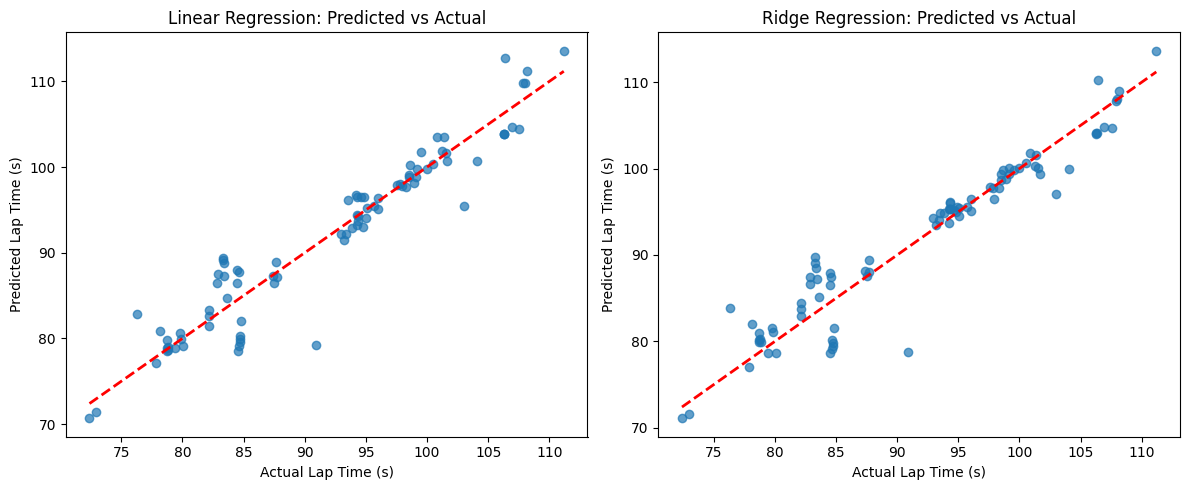


Overfitting Analysis:
Linear Regression gap: 0.069 seconds
Ridge Regression gap: -0.015 seconds


In [18]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data (we only have 80 rows)
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Driver'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()
le_year=LabelEncoder()
le_driver = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
train_df['Year_encoded'] = le_year.fit_transform(train_df['Year'])
# train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)','Year'])
X_init = X_init.fillna(0)

# Define categorical columns that should NOT be normalized
categorical_columns = ['Year_encoded','Is_Singapore', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded','Rain']

# Identify columns to normalize
continuous_columns = [col for col in X_init.columns if col not in categorical_columns]

# Fit min-max scaler only on continuous columns
norm = StandardScaler().fit(X_init[continuous_columns])

# Create normalized dataset
X_normalized = X_init.copy()
X_normalized[continuous_columns] = norm.transform(X_init[continuous_columns])

print("FINAL TRAINING DATA\n")
X = X_normalized

X = pd.DataFrame(X, columns=X_init.columns)

# Reset indices to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True) 
drivers_reset = drivers.reset_index(drop=True)

# Now create the boolean mask
valid_indices = y_reset.notna().squeeze()

# Apply the mask
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]  
drivers_clean = drivers_reset[valid_indices]

print(f"Original shape: X{X_reset.shape}, y{y_reset.shape}")
print(f"After cleaning: X{X_clean.shape}, y{y_clean.shape}")

# Now use the cleaned data for train_test_split
X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X_clean, y_clean, drivers_clean, test_size=0.25, random_state=42
)

# print(" Y TRAIN : ",y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=5.0) # Increased regularisation to prevent overfitting (from a lot of trial runs...)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Debug the array shapes
print("Debug info:")
print(f"drivers_test shape: {drivers_test.shape}")
print(f"drivers_test type: {type(drivers_test)}")
print(f"lr_test_pred shape: {lr_test_pred.shape}")
print(f"lr_test_pred type: {type(lr_test_pred)}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")

# Check if they're all the same length
print(f"drivers_test length: {len(drivers_test)}")
print(f"lr_test_pred length: {len(lr_test_pred)}")
print(f"y_test length: {len(y_test)}")

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

# === CROSS-VALIDATION ===
print("\n=== CROSS-VALIDATION RESULTS ===")

# 5-Fold Cross Validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Multiple metrics at once
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

lr_cv_results = cross_validate(lr_model, X_clean, y_clean.squeeze(), 
                               cv=cv_folds, scoring=scoring)
ridge_cv_results = cross_validate(ridge_model, X_clean, y_clean.squeeze(),
                                  cv=cv_folds, scoring=scoring)

for model_name, results in [("Linear", lr_cv_results), ("Ridge", ridge_cv_results)]:
    print(f"{model_name} Regression:")
    print(f"  CV MAE: {-results['test_neg_mean_absolute_error'].mean():.3f} ± {results['test_neg_mean_absolute_error'].std():.3f}")
    print(f"  CV RMSE: {np.sqrt(-results['test_neg_mean_squared_error'].mean()):.3f}")
    print(f"  CV R²: {results['test_r2'].mean():.3f} ± {results['test_r2'].std():.3f}")

print("X COLUMNS: ",X.columns)
print("COEFS : ",lr_model.coef_[0])
# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

# Convert everything to 1D numpy arrays
drivers_array = np.array(drivers_test).flatten()
pred_array = np.array(lr_test_pred).flatten()
actual_array = np.array(y_test).flatten()

test_results = pd.DataFrame({
    'Driver': drivers_array,
    'Predicted_LapTime': pred_array,
    'Actual_LapTime': actual_array
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [19]:
# Check correlation between features and target
correlations = X_clean.corrwith(y_clean.squeeze()).abs().sort_values(ascending=False)
print("Feature correlations with target:")
print(correlations.head(10))

# Check for perfect correlations (1.0)
perfect_corr = correlations[correlations > 0.99]
print(f"\nFeatures with correlation > 0.99:")
print(perfect_corr)

Feature correlations with target:
Best_Pace_seconds          0.848224
TrackTemp                  0.700935
Rain                       0.374405
AirTemp                    0.341156
Downforce_Level            0.295185
VSC_Prob                   0.256820
Safety_Car_Prob            0.252495
Practice_Gap_to_Fastest    0.154318
Year_encoded               0.149214
Is_Singapore               0.149214
dtype: float64

Features with correlation > 0.99:
Series([], dtype: float64)


/Users/tanvi/Documents/GitHub/f1-winner/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tanvi/Documents/GitHub/f1-winner/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [20]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility,TeamId_encoded,Race_encoded,Year_encoded
0,-1.646874,-1.646874,-0.620889,0.612992,-1.702109,0.000000,1.428026,0.357536,0,-1.088908,0.149617,1,5.0,1.062792,-0.206353,0.0,4,16,0
1,-1.473035,-1.473035,-1.707445,0.696064,-0.173650,0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5.0,1.062792,-0.206353,0.0,7,16,0
2,-0.951516,-0.951516,0.620889,0.685935,-0.360005,-0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5.0,1.062792,-0.206353,0.0,4,16,0
3,-1.125356,-1.125356,0.155222,0.657502,-0.883169,-0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5.0,1.062792,-0.206353,0.0,5,16,0
4,-0.256159,-0.256159,-0.155222,0.697829,-0.141166,-0.896803,1.428026,0.357536,0,-1.088908,0.149617,1,5.0,1.062792,-0.206353,0.0,2,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1.134556,1.134556,0.620889,1.800710,0.358062,-0.672603,-0.609994,1.042537,0,-0.318712,-0.925542,0,1.0,-0.035172,0.312419,0.0,8,3,1
355,0.613038,0.613038,0.465667,1.832582,0.944485,1.121004,-0.609994,1.042537,0,-0.318712,-0.925542,0,1.0,-0.035172,0.312419,0.0,1,3,1
356,1.308396,1.308396,0.310445,1.823568,0.778645,0.000000,-0.609994,1.042537,0,-0.318712,-0.925542,0,1.0,-0.035172,0.312419,0.0,0,3,1
357,0.960717,0.960717,-0.310445,1.834254,0.975259,0.896803,-0.609994,1.042537,0,-0.318712,-0.925542,0,1.0,-0.035172,0.312419,0.0,0,3,1


In [21]:
X.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Singapore', 'Downforce_Level', 'Safety_Car_Prob',
       'VSC_Prob', 'Position_Flexibility', 'TeamId_encoded', 'Race_encoded',
       'Year_encoded'],
      dtype='object')

In [22]:

#----------------CREATE PREDICTION DATASET-----------------

predict_df = pd.DataFrame()
predict_df['Abbreviation'] = ['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)

grid_positions = {
    'VER': 1.0,
    'SAI': 2.0, 
    'LAW': 3.0,
    'ANT': 4.0,
    'RUS': 5.0,
    'TSU': 6.0,       
    'NOR': 7.0,          
    'HAD': 8.0,
    'PIA': 9.0,    
    'LEC': 10.0,
    'ALO': 11.0,            
    'HAM': 12.0,
    'BOR': 13.0,
    'STR': 14.0,          
    'BEA': 15.0,
    'COL': 16.0,       
    'HUL': 17.0,
    'OCO': 18.0,
    'GAS': 19.0,  
    'ALB': 20.0
}

predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Baku'
predict_df['Year'] = 2025

# Encode categorical variables using the same encoders from training
predict_df['Race_encoded'] = le_race.transform(predict_df['Race'])
predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])
predict_df['Year_encoded'] = le_year.transform(predict_df['Year'])
# predict_df['Driver_encoded'] = le_driver.transform(predict_df['Abbreviation'])

predict_df['Is_Baku'] = 1

# Add Downforce Level (Baku is low downforce = 1)
predict_df['Downforce_Level'] = 1

# Get practice pace data
best_race_pace = get_best_race_pace(2025, 'Baku')
best_race_pace.drop(columns=['IsPersonalBest','Session'], inplace=True)
pace_mapping = best_race_pace.set_index('Driver')['LapTime (s)']
predict_df['Best_Pace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['Best_Pace_seconds'] - predict_df['Best_Pace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['Best_Pace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

# Weather data (predicted for race day)
predict_df['Rain'] = 0
predict_df['AirTemp'] = 21.000000
predict_df['TrackTemp'] = 28.000000
predict_df['Pressure'] = 1021.000000
predict_df['WindSpeed'] = 13.055600

# Drop original categorical columns (keep only encoded versions)
predict_df.drop(columns=['TeamId', 'Race','Year'], inplace=True)

# Rename Driver column to match training data
predict_df.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

# Create final prediction features (same structure as training)
X_predict = predict_df.drop(columns=['Driver'])
X_predict = X_predict.fillna(0)

# CRITICAL FIX: Reorder columns to match EXACTLY what the training data had
# Get the exact column order from the training data
training_columns = X_clean.columns.tolist()
print("Training columns order:", training_columns)

# Reorder prediction data to match training data exactly
X_predict = X_predict[training_columns]

print("Prediction columns order:", X_predict.columns.tolist())
print("Columns match:", list(X_predict.columns) == training_columns)

# Apply the same normalization as training data
categorical_columns = ['Year_encoded', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Rain']
continuous_columns = [col for col in X_predict.columns if col not in categorical_columns]

print("Continuous columns for normalization:", continuous_columns)

# Normalize only continuous columns using the same scaler fitted on training data
X_predict_normalized = X_predict.copy()
X_predict_normalized[continuous_columns] = norm.transform(X_predict[continuous_columns])

print("Prediction dataset shape:", X_predict_normalized.shape)
print("Training dataset shape:", X.shape)

Training columns order: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_Singapore', 'Downforce_Level', 'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility', 'TeamId_encoded', 'Race_encoded', 'Year_encoded']


KeyError: "['Is_Singapore', 'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility'] not in index"

In [ ]:
X_predict_normalized.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded'],
      dtype='object')

In [ ]:
X_predict_normalized

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level,TeamId_encoded,Race_encoded,Year_encoded
0,-0.255924,-0.255924,0.309063,1.702093,-1.226751,-0.909163,-0.5251,1.052606,0,15.866135,-0.810888,1,1,4,3,1
1,-0.603652,-0.603652,-0.309063,1.679113,-1.655019,-1.363744,-0.5251,1.052606,0,15.866135,-0.810888,1,1,4,3,1
2,0.265669,0.265669,0.309063,1.685446,-1.536993,-2.272907,-0.5251,1.052606,0,15.866135,-0.810888,1,1,2,3,1
3,-0.082060,-0.082060,-0.309063,1.692141,-1.412222,-1.591035,-0.5251,1.052606,0,15.866135,-0.810888,1,1,2,3,1
4,-0.951381,-0.951381,0.154531,1.728601,-0.732725,0.227291,-0.5251,1.052606,0,15.866135,-0.810888,1,1,5,3,1
5,-1.125245,-1.125245,-0.154531,1.729415,-0.717550,0.681872,-0.5251,1.052606,0,15.866135,-0.810888,1,1,5,3,1
6,-1.299109,-1.299109,-0.772657,1.748414,-0.363470,1.591035,-0.5251,1.052606,0,15.866135,-0.810888,1,1,6,3,1
7,-0.429788,-0.429788,0.772657,1.773565,0.105264,1.136454,-0.5251,1.052606,0,15.866135,-0.810888,1,1,6,3,1
8,-1.472974,-1.472974,-2.781566,1.772479,0.085031,2.272907,-0.5251,1.052606,0,15.866135,-0.810888,1,1,9,3,1
9,1.656582,1.656582,2.781566,1.747871,-0.373587,-2.500198,-0.5251,1.052606,0,15.866135,-0.810888,1,1,9,3,1


In [ ]:
predict_df['Driver']

0     PIA
1     NOR
2     HAM
3     LEC
4     RUS
5     ANT
6     LAW
7     HAD
8     SAI
9     ALB
10    VER
11    TSU
12    ALO
13    STR
14    BEA
15    OCO
16    BOR
17    HUL
18    GAS
19    COL
Name: Driver, dtype: object

In [ ]:
#Make Predictions

# Adjust grid position importance for Baku specifically
print("Adjusting grid position importance for Baku...")
X_predict_normalized['GridPosition'] *= 1.5
X_predict_normalized['Grid_Gap_to_Pole'] *= 1.5

predicted_lap_times = lr_model.predict(X_predict_normalized)

print("PREDICTIONS")
# print(predicted_lap_times)

results_df = pd.DataFrame({
    'Driver': predict_df['Driver'],
    'Predicted_LapTime': predicted_lap_times.flatten()
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 BAKU PODIUM")
print("===============================")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} - {results_df.iloc[0]['Predicted_LapTime']}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} - {results_df.iloc[1]['Predicted_LapTime']}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} - {results_df.iloc[2]['Predicted_LapTime']}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(20))

Adjusting grid position importance for Baku...
PREDICTIONS

PREDICTED 2025 BAKU PODIUM
🥇 P1: VER - 154.6726379309672s
🥈 P2: RUS - 155.0888943448997s
🥉 P3: ANT - 155.09488162084605s

Full Results:
   Driver  Predicted_LapTime
0     VER         154.672638
1     RUS         155.088894
2     ANT         155.094882
3     LAW         155.284884
4     NOR         155.615575
5     TSU         155.650190
6     SAI         155.812013
7     HAD         155.999166
8     PIA         156.125814
9     LEC         156.333657
10    HAM         156.531171
11    ALO         157.081750
12    STR         157.522731
13    BEA         157.645703
14    BOR         157.760870
15    ALB         157.964423
16    OCO         158.112494
17    HUL         158.137771
18    COL         158.373603
19    GAS         158.603799


In [ ]:
lr_model.score(X_test,y_test)

0.9256335417165693

In [ ]:
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_.flatten(),
    'Abs_Coefficient': abs(lr_model.coef_.flatten())
}).sort_values('Abs_Coefficient', ascending=False)

print(coefs.head(20))

                    Feature  Coefficient  Abs_Coefficient
3         Best_Pace_seconds     9.957695         9.957695
8                      Rain     8.461579         8.461579
11                  Is_Baku     5.550840         5.550840
15             Year_encoded    -5.550840         5.550840
10                TrackTemp    -5.352960         5.352960
6                   AirTemp     3.768935         3.768935
9                 WindSpeed     3.006753         3.006753
12          Downforce_Level     1.964421         1.964421
4   Practice_Gap_to_Fastest    -1.250995         1.250995
7                  Pressure    -0.722910         0.722910
1          Grid_Gap_to_Pole     0.710898         0.710898
0              GridPosition     0.710898         0.710898
5    Practice_vs_Quali_Rank     0.623945         0.623945
14             Race_encoded     0.458099         0.458099
2         Quali_vs_Teammate    -0.336593         0.336593
13           TeamId_encoded     0.039244         0.039244


In [ ]:
coefs.sort_values(by='Coefficient',ascending=False)
#Check coefficients

,Feature,Coefficient,Abs_Coefficient
3,Best_Pace_seconds,9.957695,9.957695
8,Rain,8.461579,8.461579
11,Is_Baku,5.550840,5.550840
6,AirTemp,3.768935,3.768935
9,WindSpeed,3.006753,3.006753
12,Downforce_Level,1.964421,1.964421
1,Grid_Gap_to_Pole,0.710898,0.710898
0,GridPosition,0.710898,0.710898
5,Practice_vs_Quali_Rank,0.623945,0.623945
14,Race_encoded,0.458099,0.458099
